# Creation of environment

In [0]:
!git clone https://github.com/akanazawa/hmr.git

Cloning into 'hmr'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 203 (delta 4), reused 3 (delta 1), pack-reused 190
Receiving objects: 100% (203/203), 3.87 MiB | 3.49 MiB/s, done.
Resolving deltas: 100% (80/80), done.


In [0]:
%cd hmr
!wget https://people.eecs.berkeley.edu/~kanazawa/cachedir/hmr/models.tar.gz && tar -xf models.tar.gz
!rm models.tar.gz

In [0]:
%cd data
!wget http://files.is.tuebingen.mpg.de/classner/up/datasets/up-3d.zip
!unzip up-3d.zip
!rm up-3d.zip
%cd ../

In [0]:
%cd data
!wget http://files.is.tuebingen.mpg.de/classner/up/datasets/up-s31.zip
!unzip up-s31.zip
!rm up-s31.zip
%cd ../

In [0]:
%cd data
!wget http://files.is.tuebingen.mpg.de/classner/up/datasets/upi-s1h.zip
!unzip upi-s1h.zip
!rm upi-s1h.zip
%cd ../

In [0]:
%cd data
!mkdir custom
%cd custom
!wget https://www.dropbox.com/s/5vnfyy2vfn0fx7e/001.jpg?dl=0
!mv 001.jpg?dl=0 001.jpg
%cd ../../

In [0]:
%cd data/custom
!wget https://www.dropbox.com/s/8mnxle581ip5tzd/003.jpg?dl=0
!mv 003.jpg?dl=0 003.jpg
%cd ../../

In [0]:
%cd hmr
!pip install -r requirements.txt

In [0]:
%cd hmr

# Single Image

In [0]:
"""
Demo of HMR.

Note that HMR requires the bounding box of the person in the image. The best performance is obtained when max length of the person in the image is roughly 150px. 

When only the image path is supplied, it assumes that the image is centered on a person whose length is roughly 150px.
Alternatively, you can supply output of the openpose to figure out the bbox and the right scale factor.

Sample usage:

# On images on a tightly cropped image around the person
python -m demo --img_path data/im1963.jpg
python -m demo --img_path data/coco1.png

# On images, with openpose output
python -m demo --img_path data/random.jpg --json_path data/random_keypoints.json
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
from absl import flags
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import skimage.io as io
import tensorflow as tf

from src.util import renderer as vis_util
from src.util import image as img_util
from src.util import openpose as op_util
import src.config
from src.RunModel import RunModel



In [0]:
flags.DEFINE_string('img_path', 'data/random.jpg', 'Image to run')
flags.DEFINE_string(
    'json_path', None,
    'If specified, uses the openpose output to crop the image.')

In [0]:

def visualize(img, proc_param, joints, verts, cam):
    """
    Renders the result in original image coordinate frame.
    """
    
    global Gverts
    
    cam_for_render, vert_shifted, joints_orig = vis_util.get_original(
        proc_param, verts, cam, joints, img_size=img.shape[:2])

    
    # Render results
    skel_img = vis_util.draw_skeleton(img, joints_orig)
    rend_img_overlay = renderer(
        vert_shifted, cam=cam_for_render, img=img, do_alpha=True)
    rend_img = renderer(
        vert_shifted, cam=cam_for_render, img_size=img.shape[:2])
    Gverts = rend_img
    rend_img_vp1 = renderer.rotated(
        vert_shifted, 60, cam=cam_for_render, img_size=img.shape[:2])
    rend_img_vp2 = renderer.rotated(
        vert_shifted, -60, cam=cam_for_render, img_size=img.shape[:2])

    import matplotlib.pyplot as plt
    # plt.ion()
    plt.figure()
    #plt.clf()
    plt.subplot(221)
    plt.imshow(img)
    plt.title('input')
    plt.axis('off')
    """
    plt.subplot(232)
    plt.imshow(skel_img)
    plt.title('joint projection')
    plt.axis('off')
    """
    plt.subplot(222)
    plt.imshow(rend_img_overlay)
    plt.title('3D Mesh overlay')
    plt.axis('off')
    """
    plt.subplot(234)
    plt.imshow(rend_img)
    plt.title('3D mesh')
    plt.axis('off')
    """
    plt.subplot(223)
    plt.imshow(rend_img_vp1)
    plt.title('diff vp')
    plt.axis('off')
    plt.subplot(224)
    plt.imshow(rend_img_vp2)
    plt.title('diff vp')
    plt.axis('off')
    plt.draw()
    
    
    plt.show()
    plt.subplots_adjust(left = 0.1, right = 0.2)
    # import ipdb
    # ipdb.set_trace()


def preprocess_image(img_path, json_path=None):
    img = io.imread(img_path)
    if img.shape[2] == 4:
        img = img[:, :, :3]

    if json_path is None:
        if np.max(img.shape[:2]) != config.img_size:
            #print('Resizing so the max image size is %d..' % config.img_size)
            scale = (float(config.img_size) / np.max(img.shape[:2]))
        else:
            scale = 1.
        center = np.round(np.array(img.shape[:2]) / 2).astype(int)
        # image center in (x,y)
        center = center[::-1]
    else:
        scale, center = op_util.get_bbox(json_path)

    crop, proc_param = img_util.scale_and_crop(img, scale, center,
                                               config.img_size)

    # Normalize image to [-1, 1]
    crop = 2 * ((crop / 255.) - 0.5)

    return crop, proc_param, img


def main(img_path, json_path=None):
    

    
    sess = tf.Session()
    model = RunModel(config, sess=sess)

    input_img, proc_param, img = preprocess_image(img_path, json_path)
    # Add batch dimension: 1 x D x D x 3
    input_img = np.expand_dims(input_img, 0)

    # Theta is the 85D vector holding [camera, pose, shape]
    # where camera is 3D [s, tx, ty]
    # pose is 72D vector holding the rotation of 24 joints of SMPL in axis angle format
    # shape is 10D shape coefficients of SMPL
    joints, verts, cams, joints3d, theta = model.predict(
        input_img, get_theta=True)

    visualize(img, proc_param, joints[0], verts[0], cams[0])




Iteration 0
Iteration 1
Reuse is on!
Iteration 2
Reuse is on!
Restoring checkpoint /content/hmr/src/../models/model.ckpt-667589..
INFO:tensorflow:Restoring parameters from /content/hmr/src/../models/model.ckpt-667589


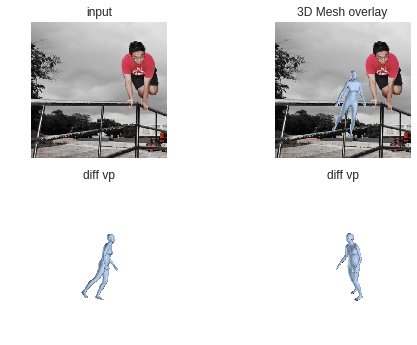

<Figure size 576x396 with 0 Axes>

In [0]:
 
if __name__ == '__main__':
    tf.reset_default_graph()
    config = flags.FLAGS
    config(["data/im19"])
    # Using pre-trained model, change this to use your own.
    config.load_path = src.config.PRETRAINED_MODEL

    config.batch_size = 1
    
    Gverts = None
    renderer = vis_util.SMPLRenderer(face_path=config.smpl_face_path)
    config.img_path = "data/s31/01301_image.png"
    main(config.img_path, config.json_path)

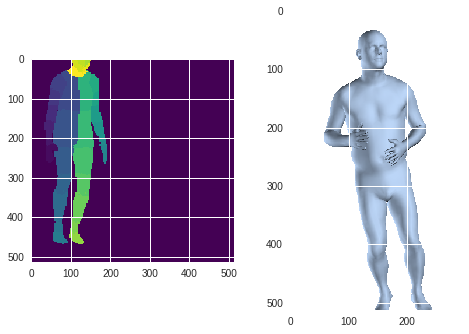

In [0]:
#img1 = plt.imread("data/s31/01410_image.png")
fg = plt.imread("data/s31/02421_ann_vis.png")[:,:,:3]

#plt.imshow(img1);
plt.subplot(121);plt.imshow(fg[:,:,:3]);
plt.subplot(122);plt.imshow(Gverts)

In [0]:

def f1score(Ypred,Ytest):

    tp = np.sum((Ypred == Ytest)[Ypred == False])
    fp = np.sum((Ypred != Ytest)[Ypred == False])
    fn = np.sum((Ypred != Ytest)[Ytest == False])
    p = tp/(tp + fp)
    r = tp/(tp + fn)
    if tp+fp ==0 or tp+fn ==0 or tp == 0: return 0


    return 2* (p*r)/(p+r)

In [0]:
fg6 = (fg != fg[0,0]).reshape(fg.shape[0]*fg.shape[1]*fg.shape[2])
Gverts6 = (Gverts != Gverts[0,0]).reshape(Gverts.shape[0]*Gverts.shape[1]*Gverts.shape[2])

In [0]:
fg6

array([False, False, False, ..., False, False, False])

In [0]:
print(((Gverts == Gverts[0,0]) == (fg == fg[0,0])).prod(2).sum()/(Gverts.shape[0]*Gverts.shape[1]))
print(f1_score(fg6,Gverts6))
print(f1score((Gverts == Gverts[0,0]),fg == fg[0,0]))

0.7638437657930836
0.0
0


In [0]:
lsps = []
for i in range(8515):
  origin = open("data/up-3d/"+ ('0000'+str(i))[-5:]+"_dataset_info.txt")
  source = origin.read()
  if "lsp " in source:
    lsps.append(i)
lsps = np.array(lsps)
    

In [0]:
lsps.shape

(1292,)

In [0]:
"""
up3d joints, same first as this numerotation

0 right ankle     
1 right knee      
2 right hip       
3 left hip       
4 left knee
5 left ankle
6 right wrist
7 right elbow
8 right shoulder
9 left shoulder
10 left elbow
11 left wrist
12 neck
13 head top
"""

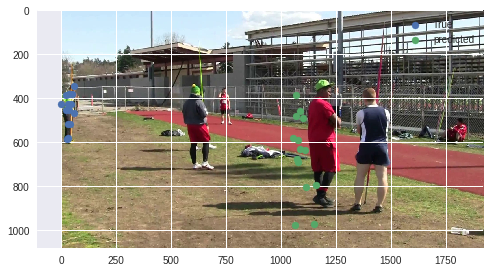

In [0]:
joints_up3d[:2].T - j1[:14]
plt.imshow(immg);
plt.scatter(joints_up3d[:2].T[:,0],joints_up3d[:2].T[:,1], label = "True");
plt.scatter(j1[:14,0],j1[:14,1],label = "predicted");
plt.legend();

In [0]:
print(((((j1[:14] - joints_up3d[:2,:].T)**2))))
print(np.sqrt((((j1[:14] - joints_up3d[:2,:].T)**2)).sum(1)).mean())

[[2.38984670e+02 8.36857752e+00]
 [4.22757525e+01 2.22229219e+01]
 [4.94494824e+01 1.09767507e+01]
 [3.24046012e+01 9.06540449e-01]
 [1.14200855e+01 5.46465386e+00]
 [1.44698132e+00 8.34226453e+00]
 [2.61883067e+02 2.50567079e+02]
 [3.61862741e+02 6.42063218e+00]
 [1.45172985e-01 1.14903980e+02]
 [4.00283010e+01 7.96418389e+00]
 [2.49223061e+00 2.73825967e-01]
 [7.44460331e+00 4.06416175e+02]
 [6.03981273e+01 7.88669860e+01]
 [1.02602740e+02 1.49505093e+00]]
10.573850679934846


7.839999999999999

# Video

In [0]:
!mkdir video

In [0]:
%cd data
!wget http://virtualhumans.mpi-inf.mpg.de/3DPW/imageFiles.zip
!unzip imageFiles.zip
!rm imageFiles.zip
%cd ../

In [0]:
%cd data
!wget http://virtualhumans.mpi-inf.mpg.de/3DPW/sequenceFiles.zip
!unzip sequenceFiles.zip
!rm sequenceFiles.zip
%cd ../

/content/hmr


In [0]:
import pickle


with open('data/sequenceFiles/validation/outdoors_parcours_00.pkl', 'r') as f:
    dat = pickle.load(f)
   

In [0]:
a = dat["poses"][0]
a

array([[-0.17644011, -1.12562375, -0.09374253, ..., -0.13156083,
         0.10304795,  0.21112804],
       [-0.16470606, -1.1385635 , -0.08915872, ..., -0.1334434 ,
         0.10316233,  0.21648029],
       [-0.14953483, -1.15576559, -0.08198828, ..., -0.13041825,
         0.10307621,  0.21256954],
       ...,
       [-0.24207454, -0.32013985,  0.03647485, ..., -0.11411826,
         0.1025939 ,  0.19033188],
       [-0.23246866, -0.32474574,  0.03717165, ..., -0.11519519,
         0.10263322,  0.19217215],
       [-0.22947021, -0.32372062,  0.02946544, ..., -0.11548661,
         0.10263087,  0.19211242]])

In [0]:
"""
SMPL MODEL:
0 : pelvis
1 : left hip               3
2 : right hip              2
3 : spine1
4 : left knee              4
5 : right knee             1
6 : spine2
7 : left ankle             5
8 : right ankle            0
9 : spine3
10 : left foot
11 : right foot
12 : neck                  12
13 : left collar
14 : right collar
15 : head                  13
16 : left shoulder         9
17 : right shoulder        8
18 : left elbow            10
19 : right elbow           7
20 : left wrist            11
21 : right wrist           6
22 : left hand
23 : right hand
"""
joint_rot3d = np.array([8,5,2,1,4,7,21,19,17,16,18,20,12,15])

In [0]:
"""
Predicted -> True
0 -> 14    nose
1 -> 12    neck
2 -> 8     r_shoulder
3 -> 7     r_elbow
4 -> 6    r_wrist
5 -> 9     l_shoulder
6 -> 10     l_elbow
7 -> 11     l_wrist
8 -> 2     r_hip
9 -> 1     r_knee
10 -> 0    r_ankle
11 -> 3    l_hip
12 -> 4    l_knee
13 -> 5    l_ankle
14 -> 16   r_eye
15 -> 15   l_eye
16 -> 18   r_ear
17 -> 17   l_ear

['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 
 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 
 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']
[0:nose,1:neck, 2:rightshoulder, 3:right elbow, 4:right wrist,5:leftshoulder, 6:left elbow,
7:left wrist, 8:right hip,9:right knee, 10:right ankle, 11:left hip, 12:left knee, 13:left ankle, 14:right eye,
15:left eye, 16:right ear, 17:left ear]
"""
rot2d=np.array([14,12,8,7,6,9,10,11,2,1,0,3,1,5,16,15,18,17])

In [0]:
def write_video(img, proc_param, joints, verts, cam,boucle = False):
    """
    Renders the result in original image coordinate frame.
    """
    global joints_up3d
    global joints_diff_fb, joints_diff_md
    global fg_metric, f1, fg
    global rendd
    global frames
    global frame_nb, frame_written

    
    

    
    if not boucle:
      
      cam_for_render, vert_shifted,joints_orig = vis_util.get_original(
            proc_param, verts, cam, joints, img_size=img.shape[:2])
      
      rend_img = renderer(
      vert_shifted, cam=cam_for_render, img_size=img.shape[:2])
      Gverts= rend_img
      fg_metric[frame_nb]=((Gverts == Gverts[0,0]) == (fg == fg[0,0])).prod(2).sum()/(Gverts.shape[0]*Gverts.shape[1])
      f1[frame_nb] = f1score(Gverts == Gverts[0,0],fg == fg[0,0])
      frame_nb += 1
      
      
      
    
    else:
      global cam_for_renders, vert_shifteds, joints_origs, imgs
      global divider
      
      if divider == 0:
        cam_for_renders[divider], vert_shifteds[divider], joints_origs[divider] = vis_util.get_original(
            proc_param, verts, cam, joints, img_size=img.shape[:2])
        
        imgs[divider] = img
        #for ar in [cam_for_renders,vert_shifteds,joints_origs]:
         # ar[2] = 1/2 * (ar[1] + ar[0])

        for i in [1,2,0]: 
          #evaluation
          cam_for_render = cam_for_renders[i]
          vert_shifted = vert_shifteds[i]
          joints_orig = joints_origs[i]
          img = imgs[i]

          """
          Evaluation on the joints, pixel wise
          #totake1 = np.equal(trueJoints[frame_nb][:2].T,np.zeros(2)).sum(1).astype(bool)
          #joints_orig[rot2d][totake1]=np.zeros((totake1.sum(),2))
          #print(((joints_orig[rot2d] - trueJoints[frame_nb][:2,:].T)**2).shape)
          #joints_diff_md[frame_nb] = np.sqrt((((joints_orig[rot2d] - trueJoints[frame_nb][:2,:].T)**2).sum(1))).mean()
          #totake2 = np.not_equal(trueJoints[frame_nb][:2].T,np.zeros(2)).sum(1).astype(bool)
          #joints_diff_fb[frame_nb] = np.linalg.norm((joints_orig[rot2d] - trueJoints[frame_nb][:2].T))
          """

          frame_nb += 1
          if frame_nb in [0,1,2]:
            break

          # Render results
          #skel_img = vis_util.draw_skeleton(img, joints_orig)
          #rend_img_overlay = renderer(
          #    vert_shifted, cam=cam_for_render, img=img, do_alpha=True)


          #rendd = renderer(
           #  vert_shifted, cam=cam_for_render, img=imgs[i], do_alpha=True)



          rend_img = renderer(
              vert_shifted, cam=cam_for_render, img_size=img.shape[:2])
          Gverts= rend_img
          fg_metric[frame_nb]=((Gverts == Gverts[0,0]) == (fg == fg[0,0])).prod(2).sum()/(Gverts.shape[0]*Gverts.shape[1])
          #rend_img_vp1 = renderer.rotated(
           #   vert_shifted, 60, cam=cam_for_render, img_size=img.shape[:2])
          #rend_img_vp2 = renderer.rotated(
           #   vert_shifted, -60, cam=cam_for_render, img_size=img.shape[:2])
          rotation = np.array([2,1,0])
          #writers[0].write(img[:,:,rotation])   #input
          #writers[1].write(skel_img[:,:,rotation])  #joint projection
          #writers[2].write(rendd[:,:,:3][:,:,rotation]) #3D Mesh Overlay
          #writers[3].write(rend_img[:,:,rotation])   #3D Mesh
          #writers[4].write(rend_img_vp1[:,:,rotation])  #diff vp
          #writers[5].write(rend_img_vp2[:,:,rotation])  #diff vp
          #frame_written += 1

      divider = (divider+ 1) %3

def main2(img_path, writers, json_path=None):

    global joints300
    
    input_img, proc_param, img = preprocess_image(img_path, json_path)
    # Add batch dimension: 1 x D x D x 3
    input_img = np.expand_dims(input_img, 0)

    # Theta is the 85D vector holding [camera, pose, shape]
    # where camera is 3D [s, tx, ty]
    # pose is 72D vector holding the rotation of 24 joints of SMPL in axis angle format
    # shape is 10D shape coefficients of SMPL
    joints, verts, cams, joints3d, theta = model.predict(
        input_img, get_theta=True)
    
    write_video(img, proc_param, joints[0], verts[0], cams[0])

In [0]:
import pickle
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
path = "data/s31/"
#with open('data/sequenceFiles/validation/outdoors_parcours_00.pkl', 'r') as f:
#    trueDat = pickle.load(f)
    
#trueJoints = trueDat["poses2d"][0]

writers = []
fourcc = cv2.VideoWriter_fourcc(*'XVID')
for title in ["input.avi","joint.avi","3d_overlay.avi","3d_mesh.avi","diff_vp_1.avi","diff_vp_2.avi"]:
  writers.append(cv2.VideoWriter("video/"+title,fourcc,20.0,(1080,1920),isColor = True))

tf.reset_default_graph()

config = flags.FLAGS
# Using pre-trained model, change this to use your own.
config.load_path = src.config.PRETRAINED_MODEL

config.batch_size = 1

sess = tf.Session()
model = RunModel(config, sess=sess)

debut =0
nb_totframes = 8515
#frames = np.zeros((nb_totframes,1920,1080,3))
frame_nb = 0
divider = 0
rendd = None
#joints300 = None


joints_diff_fb = np.zeros((nb_totframes-debut))
joints_diff_md = np.zeros(nb_totframes-debut)
fg_metric = np.zeros(nb_totframes-debut)
f1 = np.zeros(nb_totframes-debut)

imgs = np.zeros((3,1920,1080,3))
cam_for_renders = np.zeros((3,3))
vert_shifteds = np.zeros((3,6890,3))
joints_origs = np.zeros((3,19,2))
frame_written = 0
for i in tqdm(range(debut,nb_totframes)):
  #joints_up3d = np.load(path +  ('0000'+str(i))[-5:] + "_joints.npy")
  renderer = vis_util.SMPLRenderer(face_path=config.smpl_face_path)
  try: config.img_path = (path + ('0000'+str(i))[-5:] + "_image.png")
  except: print("Could not read:",(path + ('0000'+str(i))[-5:] + "_image.png"));break
  fg=plt.imread(path +  ("0000"+str(i))[-5:] + "_ann_vis.png")[:,:,:3]
  main2(config.img_path, config.json_path)
  

for writer in writers:
  writer.release()

Iteration 0
Iteration 1
Reuse is on!
Iteration 2
Reuse is on!
Restoring checkpoint /content/hmr/src/../models/model.ckpt-667589..
INFO:tensorflow:Restoring parameters from /content/hmr/src/../models/model.ckpt-667589


100%|██████████| 8515/8515 [1:05:33<00:00,  1.92it/s]


In [0]:
np.save('fg_vs_bg_acc',fg_metric)
np.save('fg_vs_bg_f1',f1)

In [0]:
(f1 <= 1).sum()

8515

0.9344505215299941
0.800618106187283


Text(0.5,1,'Evaluation on the whole up-3d dataset')

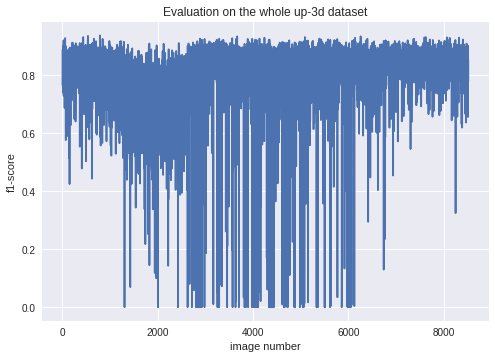

In [0]:
print(fg_metric.mean())
print(f1.mean())
plt.plot(f1);
plt.ylabel("f1-score"); plt.xlabel("image number")
plt.title("Evaluation on the whole up-3d dataset")

0.9146868408647617
0.817090832269468


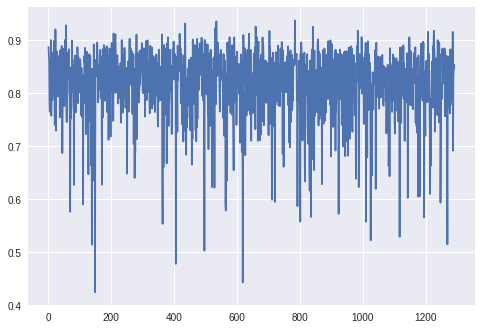

In [0]:
print(fg_metric[lsps].mean())
print(f1[lsps].mean())
plt.plot(f1[lsps])

In [0]:
(f1[lsps] == 0).sum()

0

In [0]:
np.extract(f1 < 0.1, np.arange(f1.shape[0]))

array([1301, 1422, 2005, 2421])

Text(0.5,1,u'Mean distance between joints')

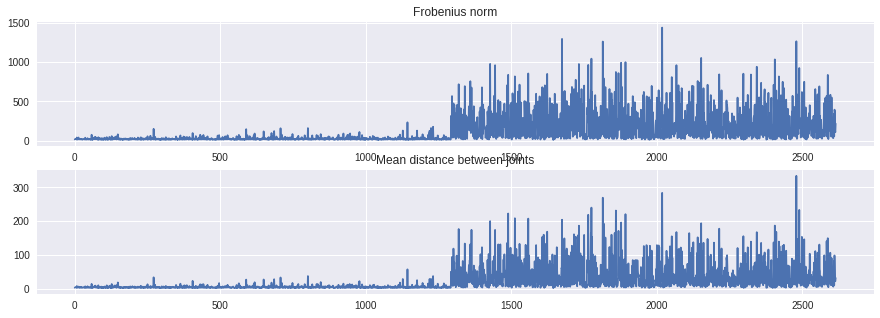

In [0]:
plt.figure(figsize = (15,5))
#plt.subplot(211);plt.plot(joints_diff_fb); plt.title("Frobenius norm")
plt.subplot(212);plt.plot(joints_diff_md); plt.title("Mean distance between joints")
#plt.subplot(223); plt.boxplot(joints_diff_fb);plt.title("Frobenius norm"); plt.ylim(-10,1800)
#plt.subplot(224); plt.boxplot(joints_diff_md);plt.title("Mean distance between joints")

In [0]:
joints_diff_md

array([nan, nan, nan, ..., nan,  0.,  0.])

In [0]:
import matplotlib.pyplot as plt
#writer = cv2.VideoWriter('output2.avi',fourcc, 20.0, (1080,1920))
writers = []
writers.append(cv2.VideoWriter('output2.avi',fourcc, 20.0, (1080,1920)))
for i in range(2):
    img = plt.imread(path + "image_0000" + str(i) + ".jpg")#[:,:,np.array([2,1,0])]
    print(type(img),img.shape)
    writers[0].write(img)
writers[0].release()

<type 'numpy.ndarray'> (1920, 1080, 3)
<type 'numpy.ndarray'> (1920, 1080, 3)


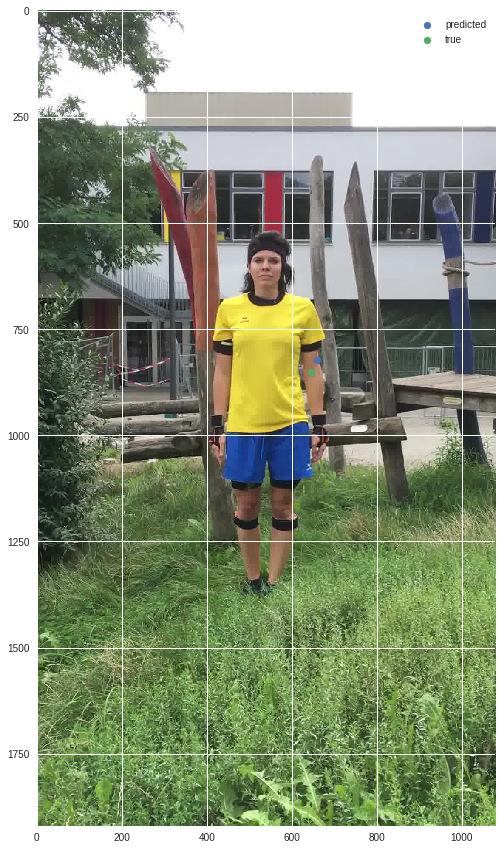

In [0]:
import matplotlib.pyplot as plt
imggg = plt.imread("data/imageFiles/outdoors_parcours_00/image_01659.jpg")

with open('data/sequenceFiles/validation/outdoors_parcours_00.pkl', 'r') as f:
    trueDat = pickle.load(f)
    
trueJoints = trueDat["jointPositions"][0]
p = 6

plt.figure(figsize = (15,15));plt.imshow(imggg);
j = trueJoints[451].reshape(24,3)[:,np.array([0,1])]
#plt.scatter(transfx(j[:,0]),transfy(j[:,1]));
plt.scatter(joints300[rot2d[p],0],joints300[rot2d[p],1], label ="predicted");
plt.scatter(a[0,p],a[1,p], label = "true")
plt.legend()

In [0]:
cmin1,dmin1= j[j[:,0].argmin()]
(xmin1,ymin1) = 370,1020

cmin2,dmin2 = j[j[:,1].argmin()]
xmin2,ymin2= 600,1510

def transfx(x):
  mx = (xmin1-xmin2)/(cmin1-cmin2)  
  px = (xmin1-mx*cmin1)
  return mx*x + px

def transfy(y):
  my = (ymin1-ymin2)/(dmin1-dmin2)
  py = (ymin1 - my*(dmin1))
  return  my*y + py


In [0]:
joints300[]

1500.0

# RunModel()

In [0]:
!rm src/RunModel.py

In [0]:
%%writefile src/RunModel.py

""" Evaluates a trained model using placeholders. """

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
from os.path import exists

from .tf_smpl import projection as proj_util
from .tf_smpl.batch_smpl import SMPL
from .models import get_encoder_fn_separate

class RunModel(object):
    def __init__(self, config, sess=None):
        """
        Args:
          config
        """
        self.config = config
        self.load_path = config.load_path
        
        # Config + path
        if not config.load_path:
            raise Exception(
                "[!] You need to specify `load_path` to load a pretrained model"
            )
        if not exists(config.load_path + '.index'):
            print('%s doesnt exist..' % config.load_path)
            import ipdb
            ipdb.set_trace()

        # Data
        self.batch_size = config.batch_size
        self.img_size = config.img_size

        self.data_format = config.data_format
        self.smpl_model_path = config.smpl_model_path
        
        input_size = (self.batch_size, self.img_size, self.img_size, 3)
        self.images_pl = tf.placeholder(tf.float32, shape=input_size)

        # Model Settings
        self.num_stage = config.num_stage
        self.model_type = config.model_type
        self.joint_type = config.joint_type
        # Camera
        self.num_cam = 3
        self.proj_fn = proj_util.batch_orth_proj_idrot

        self.num_theta = 72        
        # Theta size: camera (3) + pose (24*3) + shape (10)
        self.total_params = self.num_cam + self.num_theta + 10

        self.smpl = SMPL(self.smpl_model_path, joint_type=self.joint_type)

        # self.theta0_pl = tf.placeholder_with_default(
        #     self.load_mean_param(), shape=[self.batch_size, self.total_params], name='theta0')
        # self.theta0_pl = tf.placeholder(tf.float32, shape=[None, self.total_params], name='theta0')

        self.build_test_model_ief()

        if sess is None:
            self.sess = tf.Session()
        else:
            self.sess = sess
        
        # Load data.
        self.saver = tf.train.Saver()
        self.prepare()        


    def build_test_model_ief(self):
        # Load mean value
        self.mean_var = tf.Variable(tf.zeros((1, self.total_params)), name="mean_param", dtype=tf.float32)

        img_enc_fn, threed_enc_fn = get_encoder_fn_separate(self.model_type)
        # Extract image features.        
        self.img_feat, self.E_var = img_enc_fn(self.images_pl,
                                               is_training=False,
                                               reuse=False)
        
        # Start loop
        self.all_verts = []
        self.all_kps = []
        self.all_cams = []
        self.all_Js = []
        self.final_thetas = []
        theta_prev = tf.tile(self.mean_var, [self.batch_size, 1])
        for i in np.arange(self.num_stage):
            #print('Iteration %d' % i)
            # ---- Compute outputs
            state = tf.concat([self.img_feat, theta_prev], 1)

            if i == 0:
                delta_theta, _ = threed_enc_fn(
                    state,
                    num_output=self.total_params,
                    is_training=False,
                    reuse=False)
            else:
                delta_theta, _ = threed_enc_fn(
                    state,
                    num_output=self.total_params,
                    is_training=False,
                    reuse=True)

            # Compute new theta
            theta_here = theta_prev + delta_theta
            # cam = N x 3, pose N x self.num_theta, shape: N x 10
            cams = theta_here[:, :self.num_cam]                
            poses = theta_here[:, self.num_cam:(self.num_cam + self.num_theta)]
            shapes = theta_here[:, (self.num_cam + self.num_theta):]

            verts, Js, _ = self.smpl(shapes, poses, get_skin=True)

            # Project to 2D!
            pred_kp = self.proj_fn(Js, cams, name='proj_2d_stage%d' % i)
            self.all_verts.append(verts)
            self.all_kps.append(pred_kp)
            self.all_cams.append(cams)
            self.all_Js.append(Js)
            # save each theta.
            self.final_thetas.append(theta_here)
            # Finally)update to end iteration.
            theta_prev = theta_here


    def prepare(self):
        #print('Restoring checkpoint %s..' % self.load_path)
        self.saver.restore(self.sess, self.load_path)        
        self.mean_value = self.sess.run(self.mean_var)
            
    def predict(self, images, get_theta=False):
        """
        images: num_batch, img_size, img_size, 3
        Preprocessed to range [-1, 1]
        """
        results = self.predict_dict(images)
        if get_theta:
            return results['joints'], results['verts'], results['cams'], results[
                'joints3d'], results['theta']
        else:
            return results['joints'], results['verts'], results['cams'], results[
                'joints3d']

    def predict_dict(self, images):
        """
        images: num_batch, img_size, img_size, 3
        Preprocessed to range [-1, 1]
        Runs the model with images.
        """
        feed_dict = {
            self.images_pl: images,
            # self.theta0_pl: self.mean_var,
        }
        fetch_dict = {
            'joints': self.all_kps[-1],
            'verts': self.all_verts[-1],
            'cams': self.all_cams[-1],
            'joints3d': self.all_Js[-1],
            'theta': self.final_thetas[-1],
        }

        results = self.sess.run(fetch_dict, feed_dict)

        # Return joints in original image space.
        joints = results['joints']
        results['joints'] = ((joints + 1) * 0.5) * self.img_size

        return results
      


Overwriting src/RunModel.py


In [0]:

reload(src.RunModel)
from src.RunModel import RunModel

# Config.py

In [0]:
!rm src/config.py

In [0]:
%%writefile src/config.py

"""
Sets default args

Note all data format is NHWC because slim resnet wants NHWC.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
from absl import flags
import os.path as osp
from os import makedirs
from glob import glob
from datetime import datetime
import json

import numpy as np

curr_path = osp.dirname(osp.abspath(__file__))
model_dir = osp.join(curr_path, '..', 'models')
if not osp.exists(model_dir):
    print('Fix path to models/')
    import ipdb
    ipdb.set_trace()
SMPL_MODEL_PATH = osp.join(model_dir, 'neutral_smpl_with_cocoplus_reg.pkl')
SMPL_FACE_PATH = osp.join(curr_path, '../src/tf_smpl', 'smpl_faces.npy')

# Default pred-trained model path for the demo.
PRETRAINED_MODEL = osp.join(model_dir, 'model.ckpt-667589')

flags.DEFINE_string('smpl_model_path', SMPL_MODEL_PATH,
                    'path to the neurtral smpl model')
flags.DEFINE_string('smpl_face_path', SMPL_FACE_PATH,
                    'path to smpl mesh faces (for easy rendering)')
flags.DEFINE_string('load_path', None, 'path to trained model')
flags.DEFINE_string('pretrained_model_path', None,
                    'if not None, fine-tunes from this ckpt')
flags.DEFINE_integer('batch_size', 8,
                     'Input image size to the network after preprocessing')

# Don't change if testing:
flags.DEFINE_integer('img_size', 224,
                     'Input image size to the network after preprocessing')
flags.DEFINE_string('data_format', 'NHWC', 'Data format')
flags.DEFINE_integer('num_stage', 3, '# of times to iterate regressor')
flags.DEFINE_string('model_type', 'resnet_fc3_dropout',
                    'Specifies which network to use')
flags.DEFINE_string(
    'joint_type', 'cocoplus',
    'cocoplus (19 keypoints) or lsp 14 keypoints, returned by SMPL')

# Training settings:
# TODO! If you want to train, change this to your 'tf_datasets' or specify it with the flag.
DATA_DIR = '/scratch1/projects/tf_datasets/'

flags.DEFINE_string('data_dir', DATA_DIR, 'Where to save training models')
flags.DEFINE_string('log_dir', 'logs', 'Where to save training models')
flags.DEFINE_string('model_dir', None, 'Where model will be saved -- filled automatically')
flags.DEFINE_integer('log_img_step', 100, 'How often to visualize img during training')
flags.DEFINE_integer('epoch', 100, '# of epochs to train')

flags.DEFINE_list('datasets', ['lsp', 'lsp_ext', 'mpii', 'coco'],
                          'datasets to use for training')
flags.DEFINE_list('mocap_datasets', ['CMU', 'H3.6', 'jointLim'],
                  'datasets to use for adversarial prior training')

# Model config
flags.DEFINE_boolean(
    'encoder_only', False,
    'if set, no adversarial prior is trained = monsters')

flags.DEFINE_boolean(
    'use_3d_label', True,
    'Uses 3D labels if on.')

# Hyper parameters:
flags.DEFINE_float('e_lr', 0.001, 'Encoder learning rate')
flags.DEFINE_float('d_lr', 0.001, 'Adversarial prior learning rate')
flags.DEFINE_float('e_wd', 0.0001, 'Encoder weight decay')
flags.DEFINE_float('d_wd', 0.0001, 'Adversarial prior weight decay')

flags.DEFINE_float('e_loss_weight', 60, 'weight on E_kp losses')
flags.DEFINE_float('d_loss_weight', 1, 'weight on discriminator')


flags.DEFINE_float('e_3d_weight', 1, 'weight on E_3d')

# Data augmentation
flags.DEFINE_integer('trans_max', 20, 'Value to jitter translation')
flags.DEFINE_float('scale_max', 1.23, 'Max value of scale jitter')
flags.DEFINE_float('scale_min', 0.8, 'Min value of scale jitter')


def get_config():
    config = flags.FLAGS
    config(sys.argv)

    if 'resnet' in config.model_type:
        setattr(config, 'img_size', 224)
        # Slim resnet wants NHWC..
        setattr(config, 'data_format', 'NHWC')

    return config


# ----- For training ----- #


def prepare_dirs(config, prefix=['HMR']):
    # Continue training from a load_path
    if config.load_path:
        if not osp.exists(config.load_path):
            print("load_path: %s doesnt exist..!!!" % config.load_path)
            import ipdb
            ipdb.set_trace()
        print('continuing from %s!' % config.load_path)

        # Check for changed training parameter:
        # Load prev config param path
        param_path = glob(osp.join(config.load_path, '*.json'))[0]

        with open(param_path, 'r') as fp:
            prev_config = json.load(fp)
        dict_here = config.__dict__
        ignore_keys = ['load_path', 'log_img_step', 'pretrained_model_path']
        diff_keys = [
            k for k in dict_here
            if k not in ignore_keys and k in prev_config.keys()
            and prev_config[k] != dict_here[k]
        ]

        for k in diff_keys:
            if k == 'load_path' or k == 'log_img_step':
                continue
            if prev_config[k] is None and dict_here[k] is not None:
                print("%s is different!! before: None after: %g" %
                      (k, dict_here[k]))
            elif prev_config[k] is not None and dict_here[k] is None:
                print("%s is different!! before: %g after: None" %
                      (k, prev_config[k]))
            else:
                print("%s is different!! before: " % k)
                print(prev_config[k])
                print("now:")
                print(dict_here[k])

        if len(diff_keys) > 0:
            print("really continue??")
            import ipdb
            ipdb.set_trace()

        config.model_dir = config.load_path

    else:
        postfix = []

        # If config.dataset is not the same as default, add that to name.
        default_dataset = [
            'lsp', 'lsp_ext', 'mpii', 'h36m', 'coco', 'mpi_inf_3dhp'
        ]
        default_mocap = ['CMU', 'H3.6', 'jointLim']

        if sorted(config.datasets) != sorted(default_dataset):
            has_all_default = np.all(
                [name in config.datasets for name in default_dataset])
            if has_all_default:
                new_names = [
                    name for name in sorted(config.datasets)
                    if name not in default_dataset
                ]
                postfix.append('default+' + '-'.join(sorted(new_names)))
            else:
                postfix.append('-'.join(sorted(config.datasets)))
        if sorted(config.mocap_datasets) != sorted(default_mocap):
            postfix.append('-'.join(config.mocap_datasets))

        postfix.append(config.model_type)

        if config.num_stage != 3:
            prefix += ["T%d" % config.num_stage]

        postfix.append("Elr%1.e" % config.e_lr)

        if config.e_loss_weight != 1:
            postfix.append("kp-weight%g" % config.e_loss_weight)

        if not config.encoder_only:
            postfix.append("Dlr%1.e" % config.d_lr)
            if config.d_loss_weight != 1:
                postfix.append("d-weight%g" % config.d_loss_weight)

        if config.use_3d_label:
            print('Using 3D labels!!')
            prefix.append("3DSUP")
            if config.e_3d_weight != 1:
                postfix.append("3dsup-weight%g" % config.e_3d_weight)

        # Data:
        # Jitter amount:
        if config.trans_max != 20:
            postfix.append("transmax-%d" % config.trans_max)
        if config.scale_max != 1.23:
            postfix.append("scmax_%.3g" % config.scale_max)
        if config.scale_min != 0.8:
            postfix.append("scmin-%.3g" % config.scale_min)

        prefix = '_'.join(prefix)
        postfix = '_'.join(postfix)

        time_str = datetime.now().strftime("%b%d_%H%M")

        save_name = "%s_%s_%s" % (prefix, postfix, time_str)
        config.model_dir = osp.join(config.log_dir, save_name)

    for path in [config.log_dir, config.model_dir]:
        if not osp.exists(path):
            print('making %s' % path)
            makedirs(path)


def save_config(config):
    param_path = osp.join(config.model_dir, "params.json")

    print("[*] MODEL dir: %s" % config.model_dir)
    print("[*] PARAM path: %s" % param_path)

    config_dict = {}
    for k in dir(config):
        config_dict[k] = config.__getattr__(k)

    with open(param_path, 'w') as fp:
        json.dump(config_dict, fp, indent=4, sort_keys=True)


/content/hmr


In [0]:
reload (src.config)

DuplicateFlagError: ignored

# Renderer

In [0]:
"""
Renders mesh using OpenDr for visualization.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import cv2

from opendr.camera import ProjectPoints
from opendr.renderer import ColoredRenderer
from opendr.lighting import LambertianPointLight

colors = {
    # colorbline/print/copy safe:
    'light_blue': [0.65098039, 0.74117647, 0.85882353],
    'light_pink': [.9, .7, .7],  # This is used to do no-3d
}


class SMPLRenderer(object):
    def __init__(self,
                 img_size=224,
                 flength=500.,
                 face_path="tf_smpl/smpl_faces.npy"):
        self.faces = np.load(face_path)
        self.w = img_size
        self.h = img_size
        self.flength = flength

    def __call__(self,
                 verts,
                 cam=None,
                 img=None,
                 do_alpha=False,
                 far=None,
                 near=None,
                 color_id=0,
                 img_size=None):
        """
        cam is 3D [f, px, py]
        """
        if img is not None:
            h, w = img.shape[:2]
        elif img_size is not None:
            h = img_size[0]
            w = img_size[1]
        else:
            h = self.h
            w = self.w

        if cam is None:
            cam = [self.flength, w / 2., h / 2.]

        use_cam = ProjectPoints(
            f=cam[0] * np.ones(2),
            rt=np.zeros(3),
            t=np.zeros(3),
            k=np.zeros(5),
            c=cam[1:3])

        if near is None:
            near = np.maximum(np.min(verts[:, 2]) - 25, 0.1)
        if far is None:
            far = np.maximum(np.max(verts[:, 2]) + 25, 25)

        imtmp = render_model(
            verts,
            self.faces,
            w,
            h,
            use_cam,
            do_alpha=do_alpha,
            img=img,
            far=far,
            near=near,
            color_id=color_id)

        return (imtmp * 255).astype('uint8')

    def rotated(self,
                verts,
                deg,
                cam=None,
                axis='y',
                img=None,
                do_alpha=True,
                far=None,
                near=None,
                color_id=0,
                img_size=None):
        import math
        if axis == 'y':
            around = cv2.Rodrigues(np.array([0, math.radians(deg), 0]))[0]
        elif axis == 'x':
            around = cv2.Rodrigues(np.array([math.radians(deg), 0, 0]))[0]
        else:
            around = cv2.Rodrigues(np.array([0, 0, math.radians(deg)]))[0]
        center = verts.mean(axis=0)
        new_v = np.dot((verts - center), around) + center

        return self.__call__(
            new_v,
            cam,
            img=img,
            do_alpha=do_alpha,
            far=far,
            near=near,
            img_size=img_size,
            color_id=color_id)


def _create_renderer(w=640,
                     h=480,
                     rt=np.zeros(3),
                     t=np.zeros(3),
                     f=None,
                     c=None,
                     k=None,
                     near=.5,
                     far=10.):

    f = np.array([w, w]) / 2. if f is None else f
    c = np.array([w, h]) / 2. if c is None else c
    k = np.zeros(5) if k is None else k

    rn = ColoredRenderer()

    rn.camera = ProjectPoints(rt=rt, t=t, f=f, c=c, k=k)
    rn.frustum = {'near': near, 'far': far, 'height': h, 'width': w}
    return rn


def _rotateY(points, angle):
    """Rotate the points by a specified angle."""
    ry = np.array([[np.cos(angle), 0., np.sin(angle)], [0., 1., 0.],
                   [-np.sin(angle), 0., np.cos(angle)]])
    return np.dot(points, ry)


def simple_renderer(rn,
                    verts,
                    faces,
                    yrot=np.radians(120),
                    color=colors['light_pink']):
    # Rendered model color
    rn.set(v=verts, f=faces, vc=color, bgcolor=np.ones(3))
    albedo = rn.vc

    # Construct Back Light (on back right corner)
    rn.vc = LambertianPointLight(
        f=rn.f,
        v=rn.v,
        num_verts=len(rn.v),
        light_pos=_rotateY(np.array([-200, -100, -100]), yrot),
        vc=albedo,
        light_color=np.array([1, 1, 1]))

    # Construct Left Light
    rn.vc += LambertianPointLight(
        f=rn.f,
        v=rn.v,
        num_verts=len(rn.v),
        light_pos=_rotateY(np.array([800, 10, 300]), yrot),
        vc=albedo,
        light_color=np.array([1, 1, 1]))

    # Construct Right Light
    rn.vc += LambertianPointLight(
        f=rn.f,
        v=rn.v,
        num_verts=len(rn.v),
        light_pos=_rotateY(np.array([-500, 500, 1000]), yrot),
        vc=albedo,
        light_color=np.array([.7, .7, .7]))

    return rn.r


def get_alpha(imtmp, bgval=1.):
    h, w = imtmp.shape[:2]
    alpha = (~np.all(imtmp == bgval, axis=2)).astype(imtmp.dtype)

    b_channel, g_channel, r_channel = cv2.split(imtmp)

    im_RGBA = cv2.merge((b_channel, g_channel, r_channel, alpha.astype(
        imtmp.dtype)))
    return im_RGBA


def append_alpha(imtmp):
    alpha = np.ones_like(imtmp[:, :, 0]).astype(imtmp.dtype)
    if np.issubdtype(imtmp.dtype, np.uint8):
        alpha = alpha * 255
    b_channel, g_channel, r_channel = cv2.split(imtmp)
    im_RGBA = cv2.merge((b_channel, g_channel, r_channel, alpha))
    return im_RGBA


def render_model(verts,
                 faces,
                 w,
                 h,
                 cam,
                 near=0.5,
                 far=25,
                 img=None,
                 do_alpha=False,
                 color_id=None):
    rn = _create_renderer(
        w=w, h=h, near=near, far=far, rt=cam.rt, t=cam.t, f=cam.f, c=cam.c)

    # Uses img as background, otherwise white background.
    if img is not None:
        rn.background_image = img / 255. if img.max() > 1 else img

    if color_id is None:
        color = colors['light_blue']
    else:
        color_list = colors.values()
        color = color_list[color_id % len(color_list)]

    imtmp = simple_renderer(rn, verts, faces, color=color)

    # If white bg, make transparent.
    if img is None and do_alpha:
        imtmp = get_alpha(imtmp)
    elif img is not None and do_alpha:
        imtmp = append_alpha(imtmp)

    return imtmp


# ------------------------------


def get_original(proc_param, verts, cam, joints, img_size):
    img_size = proc_param['img_size']
    undo_scale = 1. / np.array(proc_param['scale'])

    cam_s = cam[0]
    cam_pos = cam[1:]
    principal_pt = np.array([img_size, img_size]) / 2.
    flength = 500.
    tz = flength / (0.5 * img_size * cam_s)
    trans = np.hstack([cam_pos, tz])
    vert_shifted = verts + trans

    start_pt = proc_param['start_pt'] - 0.5 * img_size
    final_principal_pt = (principal_pt + start_pt) * undo_scale
    cam_for_render = np.hstack(
        [np.mean(flength * undo_scale), final_principal_pt])

    # This is in padded image.
    # kp_original = (joints + proc_param['start_pt']) * undo_scale
    # Subtract padding from joints.
    margin = int(img_size / 2)
    kp_original = (joints + proc_param['start_pt'] - margin) * undo_scale

    return cam_for_render, vert_shifted, kp_original


def draw_skeleton(input_image, joints, draw_edges=True, vis=None, radius=None):
    """
    joints is 3 x 19. but if not will transpose it.
    0: Right ankle
    1: Right knee
    2: Right hip
    3: Left hip
    4: Left knee
    5: Left ankle
    6: Right wrist
    7: Right elbow
    8: Right shoulder
    9: Left shoulder
    10: Left elbow
    11: Left wrist
    12: Neck
    13: Head top
    14: nose
    15: left_eye
    16: right_eye
    17: left_ear
    18: right_ear
    """
    import numpy as np
    import cv2

    if radius is None:
        radius = max(4, (np.mean(input_image.shape[:2]) * 0.01).astype(int))

    colors = {
        'pink': np.array([197, 27, 125]),  # L lower leg
        'light_pink': np.array([233, 163, 201]),  # L upper leg
        'light_green': np.array([161, 215, 106]),  # L lower arm
        'green': np.array([77, 146, 33]),  # L upper arm
        'red': np.array([215, 48, 39]),  # head
        'light_red': np.array([252, 146, 114]),  # head
        'light_orange': np.array([252, 141, 89]),  # chest
        'purple': np.array([118, 42, 131]),  # R lower leg
        'light_purple': np.array([175, 141, 195]),  # R upper
        'light_blue': np.array([145, 191, 219]),  # R lower arm
        'blue': np.array([69, 117, 180]),  # R upper arm
        'gray': np.array([130, 130, 130]),  #
        'white': np.array([255, 255, 255]),  #
    }

    image = input_image.copy()
    input_is_float = False

    if np.issubdtype(image.dtype, np.float):
        input_is_float = True
        max_val = image.max()
        if max_val <= 2.:  # should be 1 but sometimes it's slightly above 1
            image = (image * 255).astype(np.uint8)
        else:
            image = (image).astype(np.uint8)

    if joints.shape[0] != 2:
        joints = joints.T
    joints = np.round(joints).astype(int)

    jcolors = [
        'light_pink', 'light_pink', 'light_pink', 'pink', 'pink', 'pink',
        'light_blue', 'light_blue', 'light_blue', 'blue', 'blue', 'blue',
        'purple', 'purple', 'red', 'green', 'green', 'white', 'white'
    ]

    if joints.shape[1] == 19:
        # parent indices -1 means no parents
        parents = np.array([
            1, 2, 8, 9, 3, 4, 7, 8, 12, 12, 9, 10, 14, -1, 13, -1, -1, 15, 16
        ])
        # Left is light and right is dark
        ecolors = {
            0: 'light_pink',
            1: 'light_pink',
            2: 'light_pink',
            3: 'pink',
            4: 'pink',
            5: 'pink',
            6: 'light_blue',
            7: 'light_blue',
            8: 'light_blue',
            9: 'blue',
            10: 'blue',
            11: 'blue',
            12: 'purple',
            17: 'light_green',
            18: 'light_green',
            14: 'purple'
        }
    elif joints.shape[1] == 19:
        parents = np.array([
            1,
            2,
            8,
            9,
            3,
            4,
            7,
            8,
            -1,
            -1,
            9,
            10,
            13,
            -1,
        ])
        ecolors = {
            0: 'light_pink',
            1: 'light_pink',
            2: 'light_pink',
            3: 'pink',
            4: 'pink',
            5: 'pink',
            6: 'light_blue',
            7: 'light_blue',
            10: 'light_blue',
            11: 'blue',
            12: 'purple'
        }
    else:
        print('Unknown skeleton!!')
        import ipdb
        ipdb.set_trace()

    for child in xrange(len(parents)):
        point = joints[:, child]
        # If invisible skip
        if vis is not None and vis[child] == 0:
            continue
        if draw_edges:
            cv2.circle(image, (point[0], point[1]), radius, colors['white'],
                       -1)
            cv2.circle(image, (point[0], point[1]), radius - 1,
                       colors[jcolors[child]], -1)
        else:
            # cv2.circle(image, (point[0], point[1]), 5, colors['white'], 1)
            cv2.circle(image, (point[0], point[1]), radius - 1,
                       colors[jcolors[child]], 1)
            # cv2.circle(image, (point[0], point[1]), 5, colors['gray'], -1)
        pa_id = parents[child]
        if draw_edges and pa_id >= 0:
            if vis is not None and vis[pa_id] == 0:
                continue
            point_pa = joints[:, pa_id]
            cv2.circle(image, (point_pa[0], point_pa[1]), radius - 1,
                       colors[jcolors[pa_id]], -1)
            if child not in ecolors.keys():
                print('bad')
                import ipdb
                ipdb.set_trace()
            cv2.line(image, (point[0], point[1]), (point_pa[0], point_pa[1]),
                     colors[ecolors[child]], radius - 2)

    # Convert back in original dtype
    if input_is_float:
        if max_val <= 1.:
            image = image.astype(np.float32) / 255.
        else:
            image = image.astype(np.float32)

    return image


def draw_text(input_image, content):
    """
    content is a dict. draws key: val on image
    Assumes key is str, val is float
    """
    import numpy as np
    import cv2
    image = input_image.copy()
    input_is_float = False
    if np.issubdtype(image.dtype, np.float):
        input_is_float = True
        image = (image * 255).astype(np.uint8)

    black = np.array([0, 0, 0])
    margin = 15
    start_x = 5
    start_y = margin
    for key in sorted(content.keys()):
        text = "%s: %.2g" % (key, content[key])
        cv2.putText(image, text, (start_x, start_y), 0, 0.45, black)
        start_y += margin

    if input_is_float:
        image = image.astype(np.float32) / 255.
    return image


# Openpose

In [0]:
"""
Script to convert openpose output into bbox
"""
import json
import numpy as np


def read_json(json_path):
    with open(json_path) as f:
        data = json.load(f)
    kps = []
    for people in data['people']:
        kp = np.array(people['pose_keypoints']).reshape(-1, 3)
        kps.append(kp)
    return kps


def get_bbox(json_path, vis_thr=0.2):
    kps = read_json(json_path)
    # Pick the most confident detection.
    scores = [np.mean(kp[kp[:, 2] > vis_thr, 2]) for kp in kps]
    kp = kps[np.argmax(scores)]
    vis = kp[:, 2] > vis_thr
    vis_kp = kp[vis, :2]
    min_pt = np.min(vis_kp, axis=0)
    max_pt = np.max(vis_kp, axis=0)
    person_height = np.linalg.norm(max_pt - min_pt)
    if person_height == 0:
        print('bad!')
        import ipdb
        ipdb.set_trace()
    center = (min_pt + max_pt) / 2.
    scale = 150. / person_height

    return scale, center


# Projection

In [0]:
""" 
Util functions implementing the camera

@@batch_orth_proj_idrot
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

def batch_orth_proj_idrot(X, camera, name=None):
    """
    X is N x num_points x 3
    camera is N x 3
    same as applying orth_proj_idrot to each N 
    """
    with tf.name_scope(name, "batch_orth_proj_idrot", [X, camera]):
        # TODO check X dim size.
        # tf.Assert(X.shape[2] == 3, [X])

        camera = tf.reshape(camera, [-1, 1, 3], name="cam_adj_shape")

        X_trans = X[:, :, :2] + camera[:, :, 1:]

        shape = tf.shape(X_trans)
        return tf.reshape(
            camera[:, :, 0] * tf.reshape(X_trans, [shape[0], -1]), shape)
